# NYS_02_rasterize_labels

In [2]:
from pathlib import Path
import os
workdir = Path("/Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL/")
print(workdir)
os.chdir(workdir)
current_working_dir = Path.cwd()
print(f"Current working directory is now: {current_working_dir}")

/Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL
Current working directory is now: /Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL


In [3]:
import rasterio
from rasterio import features
import geopandas as gpd
import numpy as np
import sys

In [4]:
# === Testing Args ===
args = ["Data/NY_HUCS/NY_Cluster_Zones_250_NAomit.gpkg",
        208,
        "Data/Training_Data/Wetland_Polygons_For_DL/",
        "Data/TerrainProcessed/HUC_DEMs/",
        "Data/Training_Data/DL_HUC_Extracted_Training_Data/"]

In [5]:
# === Terminal Import Args ===
# args = sys.argv

In [6]:
# === Cluster Import ===
# ny_hucs = gpd.read_file(args[0], where=f"cluster = '{args[1]}' AND huc12 = '{args[2]}'")
aoi_hucs = gpd.read_file(args[0], where=f"cluster = '{args[1]}'")

# === CLASS MAPPING ===
class_mapping = {
    'EMW': 1,  # Emergent Wetland
    'FSW': 2,  # Forested Wetland
    'SSW': 3,  # Shrub Scrub Wetland
    'OWW': 4,  # Open Water Wetland
}

coarse_class_mapping = {
    'EMW': 1,  # Emergent Wetland
    'FSW': 1,  # Forested Wetland
    'SSW': 1,  # Shrub Scrub Wetland
    'OWW': 1,  # Open Water Wetland
}


In [10]:
for i in aoi_hucs["huc12"]:
    # === FILE PATHS ===
    wetlands_path = list(Path(f"{args[2]}").glob(f"*{i}*.gpkg"))[0]
    dem_path = list(Path(f"{args[3]}").glob(f"*{i}.tif"))[0]
    output_path = args[4] + f"cluster_{args[1]}_huc_{i}_labels.tif"
    print(dem_path)

    with rasterio.open(dem_path) as src:
        profile = src.profile.copy()
        transform = src.transform
        out_shape = (src.height, src.width)

    # === LOAD AND PREPARE WETLANDS ===
    wetlands = gpd.read_file(wetlands_path)
    # Add numeric class values
    wetlands['class_value'] = wetlands['MOD_CLASS'].map(coarse_class_mapping)

    # Check for any unmapped classes
    if wetlands['class_value'].isna().any():
        unmapped = wetlands[wetlands['class_value'].isna()]['MOD_CLASS'].unique()
        print(f"WARNING: Unmapped classes found: {unmapped}")
    
    # Create list of (geometry, value) tuples for rasterization
    shapes = [(geom, value) for geom, value in zip(wetlands.geometry, wetlands['class_value'])]

    # === RASTERIZE ===
    label_raster = features.rasterize(
        shapes=shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0,  # Background value
        dtype=np.uint8
    )

    # === SAVE OUTPUT ===
    profile.update(
        count=1,
        dtype=np.uint8,
        nodata=255  # Use 255 as nodata since 0 is background
    )
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(label_raster, 1)
    
    print(f"Saved label raster to: {output_path}")

    # === SUMMARY ===
    print("\nClass distribution (pixel counts):")
    unique, counts = np.unique(label_raster, return_counts=True)
    total_pixels = label_raster.size
    for val, count in zip(unique, counts):
        #class_name = {0: 'Background', 1: 'EMW', 2: 'FSW', 3: 'SSW', 4: 'OWW'}.get(val, 'Unknown')
        coarse_class_name = {0: 'Background', 1: 'WET'}.get(val, 'Unknown')
        percentage = (count / total_pixels) * 100
        print(f"  {coarse_class_name} ({val}): {count:,} pixels ({percentage:.2f}%)")

Data/TerrainProcessed/HUC_DEMs/cluster_208_huc_041402011002.tif
Saved label raster to: Data/Training_Data/DL_HUC_Extracted_Training_Data/cluster_208_huc_041402011002_labels.tif

Class distribution (pixel counts):
  Background (0): 212,171,635 pixels (98.23%)
  WET (1): 3,828,365 pixels (1.77%)
Data/TerrainProcessed/HUC_DEMs/cluster_208_huc_041402011004.tif
Saved label raster to: Data/Training_Data/DL_HUC_Extracted_Training_Data/cluster_208_huc_041402011004_labels.tif

Class distribution (pixel counts):
  Background (0): 177,141,197 pixels (98.41%)
  WET (1): 2,858,803 pixels (1.59%)
Data/TerrainProcessed/HUC_DEMs/cluster_208_huc_041402011010.tif
Saved label raster to: Data/Training_Data/DL_HUC_Extracted_Training_Data/cluster_208_huc_041402011010_labels.tif

Class distribution (pixel counts):
  Background (0): 249,229,094 pixels (98.90%)
  WET (1): 2,770,906 pixels (1.10%)
Data/TerrainProcessed/HUC_DEMs/cluster_208_huc_041402011009.tif
Saved label raster to: Data/Training_Data/DL_HUC_Ex

## Below here is single raster rasterization 

In [13]:
with rasterio.open("Data/Training_Data/DL_HUC_Extracted_Training_Data/cluster_208_huc_041402011002_labels.tif") as src:
    test = src.read()

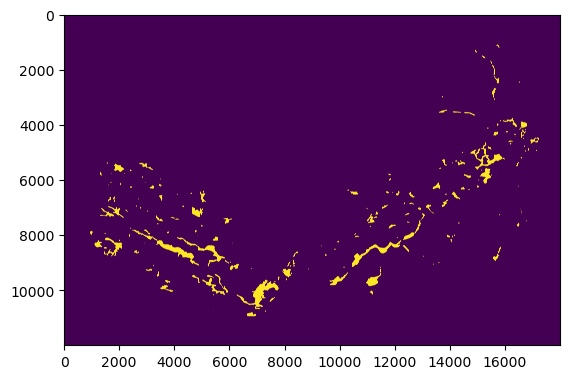

In [16]:
import matplotlib.pyplot as plt
plt.imshow(test.squeeze())

In [12]:
!jupyter nbconvert --to script Python_Code_Analysis/DL_Implement/NYS_02_rasterize_labels.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove"}'

[NbConvertApp] Converting notebook Python_Code_Analysis/DL_Implement/NYS_02_rasterize_labels.ipynb to script
[NbConvertApp] Writing 850 bytes to Python_Code_Analysis/DL_Implement/NYS_02_rasterize_labels.py
